# Etsy Pricing Model

Here is a brief description of the project / model.

**Name** &nbsp; Rebecca Neel

**Date** &nbsp; 11 July, 2023 -

## Import Packages

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestRegressor

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.base import clone

Set a seed for random state.

In [2]:
seed = 92308

## Load and Clean Data

The following data was scraped from Etsy between July 7 and July 11, 2023. (See [this notebook](web-scraping.ipynb) for more details.)

In [3]:
df = pd.read_csv('Data/proof_of_concept_model.csv', index_col=0)
df.head()

,product_name,product_url,brand_type,brand_name,price,currency,position,avg_rating,review_count,product_description,...,later_days_to_arrival,current_date,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
index,,,,,,,,,,,,,,,,,,,,,
29337,School start PDF template candle tattoo candle...,https://www.etsy.com/listing/1438910230/school...,Brand,HellooAnni,2.4,USD,10,4.9766,1363.0,This product is a downloadable digital file :)...,...,NaN,2023-07-11,HellooAnni,Lovingly Made Clothes & Accessories <3<3,"Emsdetten, Germany",7869.0,872.0,5.0,1375.0,2020.0
144399,"Endless Summer, Soy Candle, Jar Candles, Wood ...",https://www.etsy.com/listing/1144400794/endles...,Brand,ChineshasCloset,16.0,USD,16,4.9691,2420.0,Berry sorbet with light hints of summer flower...,...,17 days 00:00:00,2023-07-11,ChineshasCloset,AWAKEN YOUR SENSES WITH AROMATIC SCENTED CANDL...,"Nashville, Tennessee",8276.0,1172.0,5.0,2420.0,2017.0
147618,Mystery Item from our wonky or Overstock Shelf...,https://www.etsy.com/listing/1075221942/myster...,Brand,TeresaLynnsSimpleLux,12.0,USD,19,4.9475,25699.0,We literally don&#39;t even know what you are ...,...,7 days 00:00:00,2023-07-11,TeresaLynnsSimpleLux,Pure Soy Wax Wooden Wick Candles and Skin Care,"Monrovia, Indiana",87673.0,10218.0,5.0,25723.0,2013.0
16123,Light Teal Turquoise Rustic Unscented Pillar C...,https://www.etsy.com/listing/198199650/light-t...,Brand,StillWaterCandles,16.0,USD,44,4.9282,3750.0,This large light teal unscented rustic pillar ...,...,9 days 00:00:00,2023-07-11,StillWaterCandles,Handmade Rustic Pillar Candles - Free Ship ov...,"Missouri, United States",20080.0,3958.0,5.0,3752.0,2011.0
7595,Fall Candle / Pure Soy / Autumn Candle / Fall ...,https://www.etsy.com/listing/251445692/fall-ca...,Brand,TheDancingWick,15.0,USD,12,4.9323,29144.0,These candles are my version of the white pump...,...,10 days 00:00:00,2023-07-11,TheDancingWick,"Personalized Soy Candles, Favors & Sugar scrubs","Bixby, Oklahoma",150866.0,21155.0,5.0,29173.0,2011.0


Check null values.

In [4]:
df.isna().sum()

product_name                     0
product_url                      0
brand_type                       0
brand_name                       0
price                            0
currency                         0
position                         0
avg_rating                     274
review_count                   274
product_description              0
seller_response_time          1359
return_and_exchange_policy     159
item_listing_date              145
item_favorites                 305
early_est_arrival              469
later_est_arrival              469
early_days_to_arrival          469
later_days_to_arrival          469
current_date                     0
name                             0
shop_description                 0
location                         1
num_sales                        0
num_admirers                     0
avg_item_review_rounded        272
num_item_reviews               272
on_etsy_since                    0
dtype: int64

### Summary of Cleaning Steps to be Applied

Etsy does not publicize the number of reviews that a shop (brand) has received if the items sold by that shop have not received any reviews in the last year. These shops can probably safely have their review count imputed with the mean. However, for brands which have only been on Etsy since this year, it is safe to say that a null review count reflects a true review count of zero, so we will replace these null values with 0 before imputing the rest with the mean. (The average item review, rounded, and the number of item reviews can be treated similarly.)

It also makes sense to impute the estimated number of days to delivery (minimum and maximum) with the mean. The item listing date can be converted to a "number of days since originally listed" feature and imputed with the mean, as well.

For the two categorical variables (seller response time and the listed return & exchange policy,) it makes sense to treat null values as their own category (having no policy listed might influence buyer trust.)

Finally, the number of favorites that an item has received is not listed on the item's product page if it has not received any favorites, so null values for this feature can be replaced by zero.

Location will not be included in the baseline model (and probably not in the MVP model), but it could be treated as a categorical variable later if we take the time to map more specific locations to broader regions (e.g. northeast United States, eastern Europe, etc.)

Ultimately, the following features will not be included in the MVP model:
- product name *
- product url
- brand type (all the same)
- brand name *
- price (this is the target)
- currency (all the same)
- position
- product description *
- item listing date (use days since listed instead)
- early estimated arrival
- later estimated arrival
- current date
- name (this is the name of the brand, from the brand data dataframe)
- shop description *
- location **

\* These features are NLP features that could be included later.

\** Location could be included later after mapping to broader categories (see above.)

For brands with null review count and on_etsy_since = current year, set review count to 0. We will assume that these sellers have not received any reviews yet.

In [5]:
df.loc[(df.review_count.isna())&(df.on_etsy_since==2023), 'review_count'] = 0

Repeat the above step for avg_item_review and num_item_reviews.

In [5]:
df.loc[(df.num_item_reviews.isna())&(df.on_etsy_since==2023), 'num_item_reviews'] = 0

Other sellers with a null review count likely have not received any reviews in the past year, or their shop has gone inactive since we scraped the initial product data. We will impute these missing values with the mean.

**To be imputed (with the mean):**

avg_rating, avg_item_review_rounded

review_count, num_item_reviews

Return and exchange policy can be categorized into: "not accepted", "free", "cost", "date-restricted", and "not listed".

Replace null values with the string "Not listed."

In [6]:
df.loc[df.return_and_exchange_policy.isna(), 'return_and_exchange_policy'] = "Not listed"

Map return and exchange policies to return and exchange policy categories.

In [7]:
# all costs start with $; date restricted start with "J" or "A" for Jul or Aug
df['return_and_exchange_policy_category'] = df.return_and_exchange_policy.map(lambda x: x[0])

df.loc[df.return_and_exchange_policy_category == 'J', 'return_and_exchange_policy_category'] = 'date_restricted'

df.loc[df.return_and_exchange_policy_category == 'A', 'return_and_exchange_policy_category'] = 'date_restricted'

df.loc[df.return_and_exchange_policy_category == '$', 'return_and_exchange_policy_category'] = 'cost'

df.loc[df.return_and_exchange_policy == 'Not accepted', 'return_and_exchange_policy_category'] = 'not_accepted'

df.loc[df.return_and_exchange_policy == 'Free', 'return_and_exchange_policy_category'] = 'free'

df.loc[df.return_and_exchange_policy == 'Not listed', 'return_and_exchange_policy_category'] = 'not_listed'

In [8]:
df.return_and_exchange_policy_category.value_counts()

not_accepted       2592
date_restricted    1326
cost               1316
free                647
not_listed          159
Name: return_and_exchange_policy_category, dtype: int64

Get days since listing was first posted.

In [9]:
df['days_since_listed'] = pd.to_datetime(df.current_date) - pd.to_datetime(df.item_listing_date)

We will impute null values in the above column with the mean.

Replace null values for "item_favorites" with 0. (This information is not displayed if an item has not been favorited by anyone, so it is null after scraping.)

In [10]:
df.loc[df.item_favorites.isna(), 'item_favorites'] = 0

Impute early and later days to arrival with the mean.

Re-word categories for seller response time.

In [11]:
df.seller_response_time.value_counts()

This seller usually responds within a few hours.    3138
This seller usually responds within 24 hours.       1543
Name: seller_response_time, dtype: int64

In [12]:
df.seller_response_time = \
df.seller_response_time.replace({'This seller usually responds within a few hours.': 'within_a_few_hours',
                                 'This seller usually responds within 24 hours.': 'within_24_hours',
                                 None: 'none_given'})

In [13]:
df.seller_response_time.value_counts()

within_a_few_hours    3138
within_24_hours       1543
none_given            1359
Name: seller_response_time, dtype: int64

Convert datetime objects to float, to avoid issues imputing the mean.

For early days to arrival and later days to arrival, give the number of days as an integer for all non-null values.

(Code note for cell below: the first four lines locate only non-null values and replace them with an integer version of the number of days -- which is currently given as a datetime difference which Pandas interprets as a string. The last two lines can then be used to set the datatype of each column to float.)

In [39]:
df.loc[~df.early_days_to_arrival.isna(), 'early_days_to_arrival'] = \
df.early_days_to_arrival.dropna().map(lambda x: int(' '.join(x.split()[:1])))

df.loc[~df.later_days_to_arrival.isna(), 'later_days_to_arrival'] = \
df.later_days_to_arrival.dropna().map(lambda x: int(' '.join(x.split()[:1])))

df.early_days_to_arrival = df.early_days_to_arrival.astype(float)
df.later_days_to_arrival = df.later_days_to_arrival.astype(float)

Give the number of days since an item was listed (on Etsy) as a float.

(Code note for cell below: once again, the first two lines replace non-null values with the integer version of their current value which is given as a "timedelta64\[ns\]" datatype; the third line replaces the string "NaT" which results from a null datetime value with a true null value; the last line changes the datatype of this feature to a float.)

In [20]:
df.loc[~(df.days_since_listed.isna()), 'days_since_listed'] = \
df.days_since_listed.dropna().map(lambda x: int(str(x).split()[0]))

df.loc[df.days_since_listed.map(lambda x: str(x)) == 'NaT', 'days_since_listed'] = None

df.days_since_listed = df.days_since_listed.astype(float)

## Exploratory Data Analysis

In the following sections, I explore the distribution of features and target, as well as potential correlation between features and target.

### Features

#### Numerical

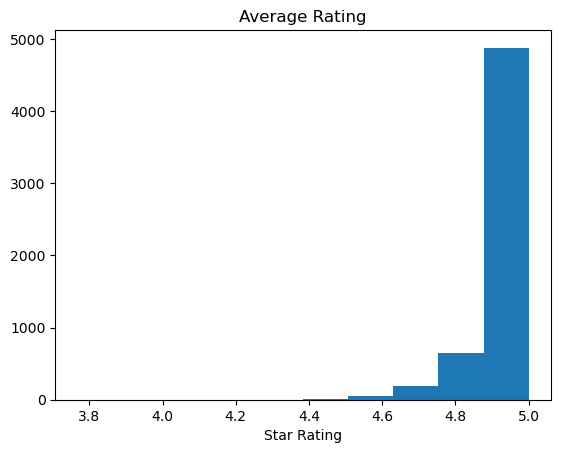

In [53]:
fig, ax = plt.subplots()

df.avg_rating.plot(kind='hist', ax=ax)
ax.set(title='Average Rating', ylabel='', xlabel='Star Rating');

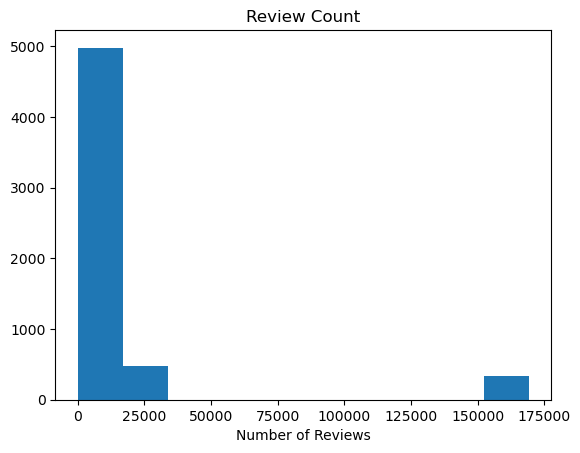

In [55]:
fig, ax = plt.subplots()

df.review_count.plot(kind='hist', ax=ax)
ax.set(title='Review Count', ylabel='', xlabel='Number of Reviews');

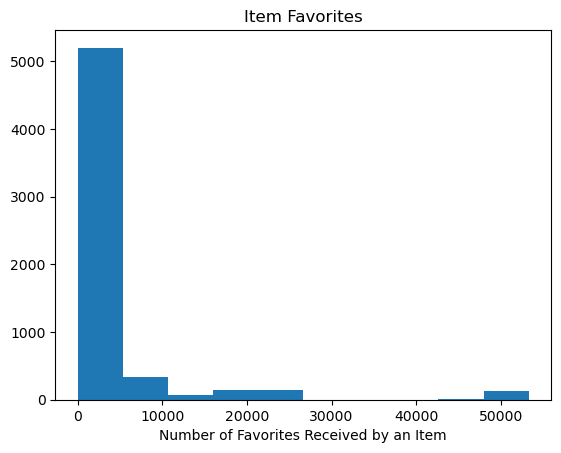

In [56]:
fig, ax = plt.subplots()

df.item_favorites.plot(kind='hist', ax=ax)
ax.set(title='Item Favorites', ylabel='', xlabel='Number of Favorites Received by an Item');

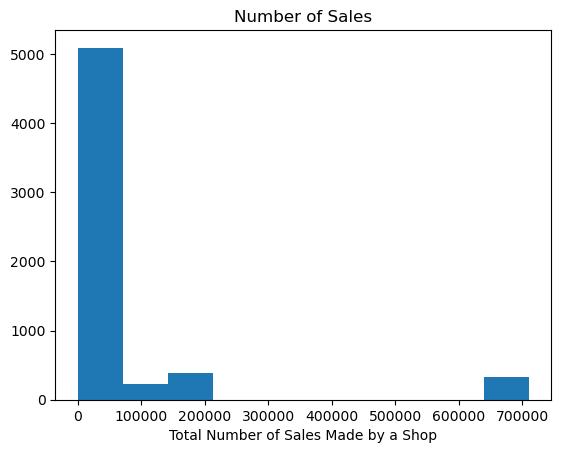

In [58]:
fig, ax = plt.subplots()

df.num_sales.plot(kind='hist', ax=ax)
ax.set(title='Number of Sales', ylabel='', xlabel='Total Number of Sales Made by a Shop');

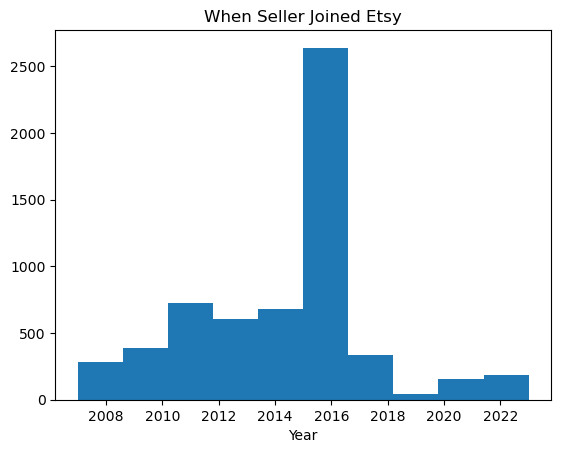

In [60]:
fig, ax = plt.subplots()

df.on_etsy_since.plot(kind='hist', ax=ax)
ax.set(title='When Seller Joined Etsy', ylabel='', xlabel='Year');

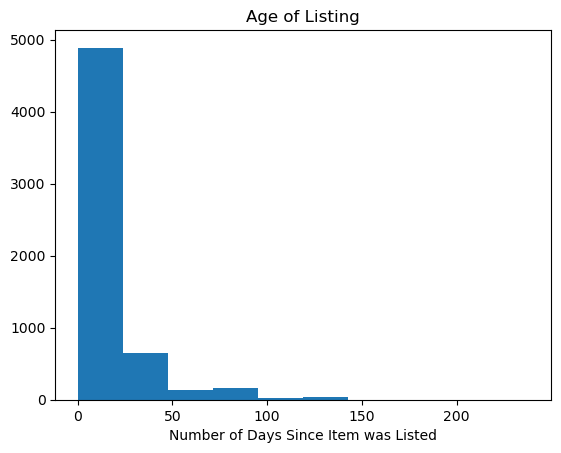

In [63]:
fig, ax = plt.subplots()

df.days_since_listed.plot(kind='hist', ax=ax)
ax.set(title='Age of Listing', ylabel='', xlabel='Number of Days Since Item was Listed');

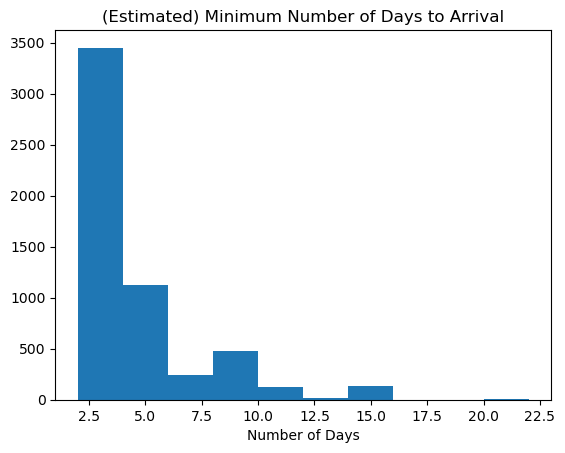

In [66]:
fig, ax = plt.subplots()

df.early_days_to_arrival.plot(kind='hist', ax=ax)
ax.set(title='(Estimated) Minimum Number of Days to Arrival', ylabel='', xlabel='Number of Days');

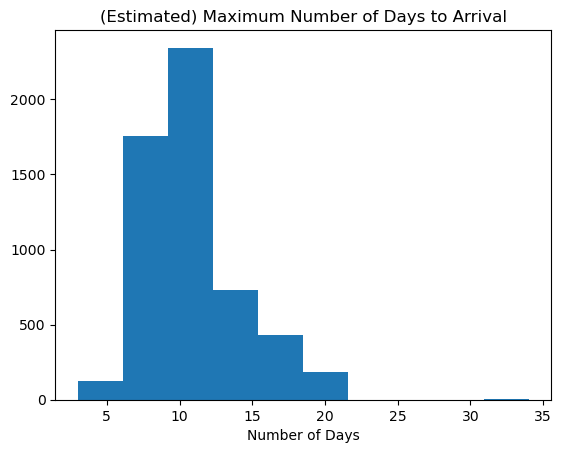

In [67]:
fig, ax = plt.subplots()

df.later_days_to_arrival.plot(kind='hist', ax=ax)
ax.set(title='(Estimated) Maximum Number of Days to Arrival', ylabel='', xlabel='Number of Days');

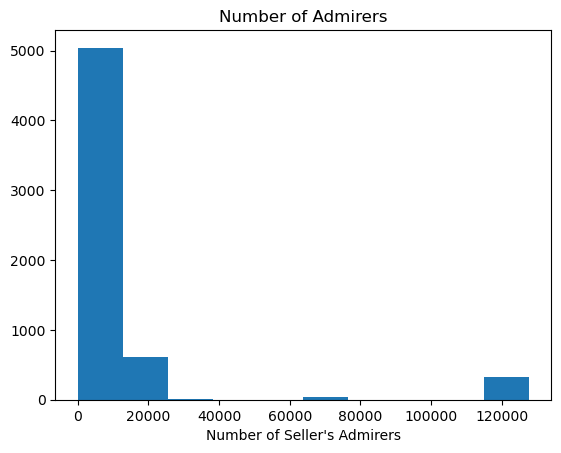

In [69]:
fig, ax = plt.subplots()

df.num_admirers.plot(kind='hist', ax=ax)
ax.set(title='Number of Admirers', ylabel='', xlabel="Number of Seller's Admirers");

#### Categorical

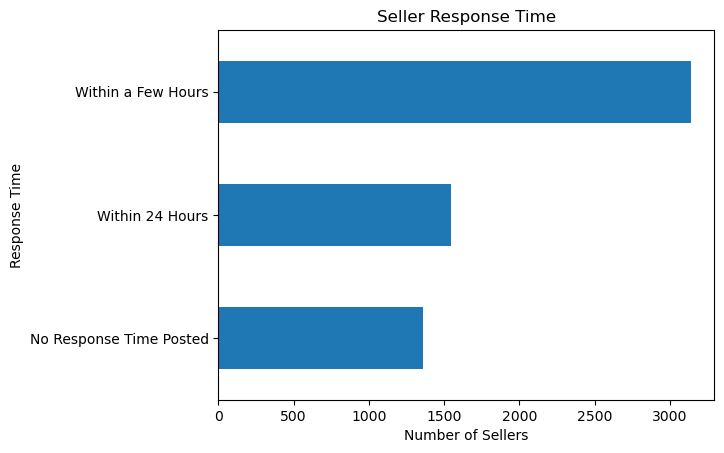

In [78]:
fig, ax = plt.subplots()

df.seller_response_time.value_counts().plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set(title='Seller Response Time', ylabel='Response Time', xlabel='Number of Sellers')
ax.set_yticklabels(['Within a Few Hours', 'Within 24 Hours', 'No Response Time Posted']);

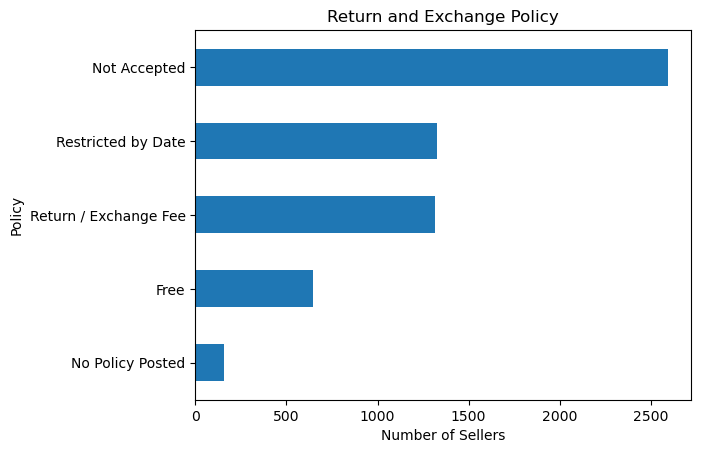

In [79]:
fig, ax = plt.subplots()

df.return_and_exchange_policy_category.value_counts().plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set(title='Return and Exchange Policy', ylabel='Policy', xlabel='Number of Sellers')
ax.set_yticklabels(['Not Accepted', 'Restricted by Date', 'Return / Exchange Fee', 'Free', 'No Policy Posted']);

## Correlation

Check for correlations between numerical features, and correlations of numerical features with the target. The heatmap will be easier to read if we remove the diagonal and lower "triangle" of the matrix (to avoid extraneous and repetitive information, respectively) so do so using numpy functions.

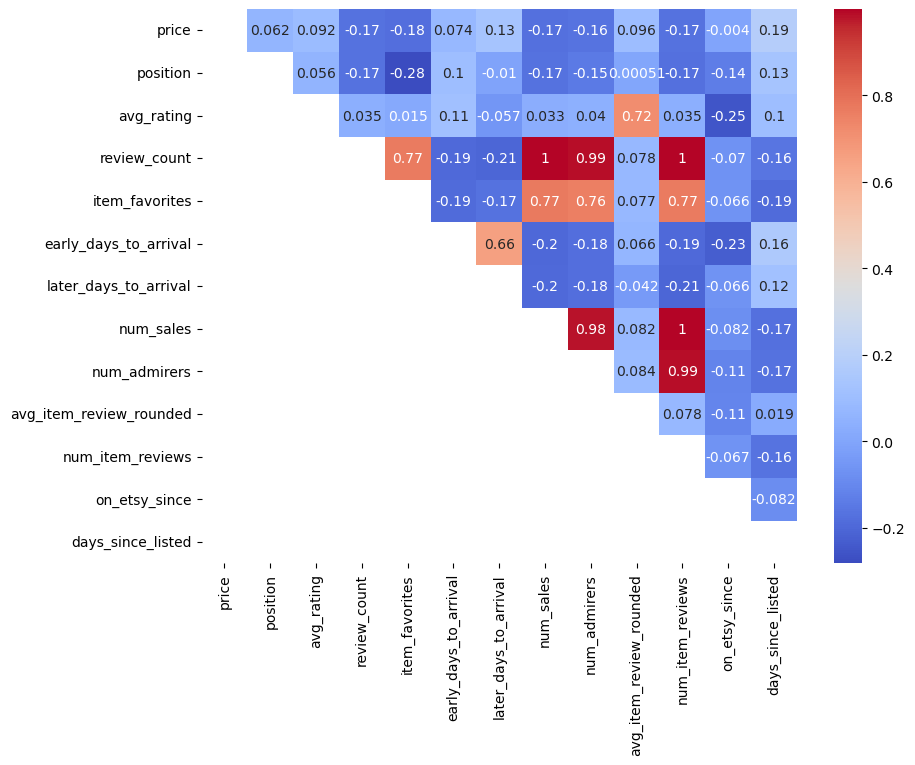

In [83]:
# remove diagonal and repeated values; k=1 to exclude diagonal
upperMatrix = df.corr(numeric_only=True).where(np.triu(np.ones(df.corr(numeric_only=True).shape), k=1).astype(bool))

fig, ax = plt.subplots(figsize=(9.6, 7.2))

# print(fig.get_size_inches()) # check current fig size to preserve dimensions when scaling

sns.heatmap(upperMatrix, annot=True, fmt='.2g', cmap='coolwarm', ax=ax);

Review count is strongly correlated with number of sales, number of admirers and number of item reviews. The number of favorites that an item has is also strongly correlated to the above four features, although substantially less so.

Unfortunately, very few numerical features in the dataset have a strong correlation to price. :(

Most positively correlated feature to price: days_since_listed

Most negatively correlated features to price: num_sales and num_admirers

*(Perhaps lower-priced candles tend to sell more frequently and produce more loyalty to the seller.)*

### "Correlation" of Categorical Features with Target

How does response time affect price?

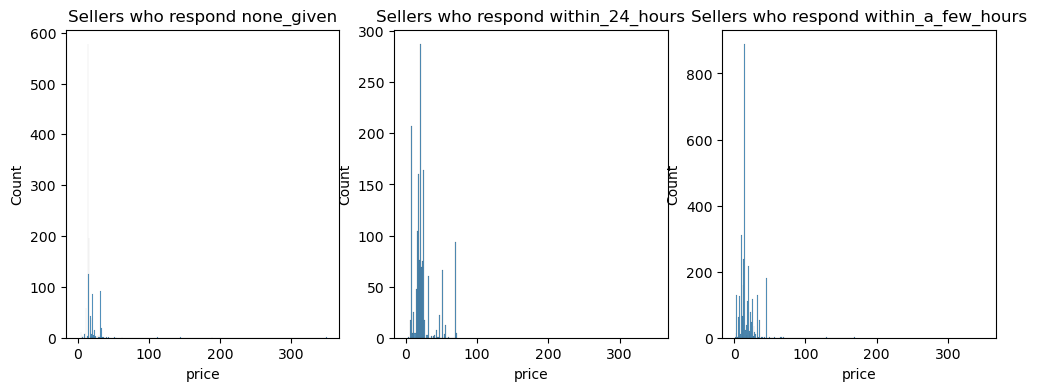

In [85]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4), sharex=True)
i=0

for response_time in np.unique(df.seller_response_time):
    sns.histplot(df.loc[df.seller_response_time==response_time, 'price'], ax=ax[i])
    ax[i].set_title(f'Sellers who respond {response_time}');
    i+=1

How does a listed return and exchange policy affect price?

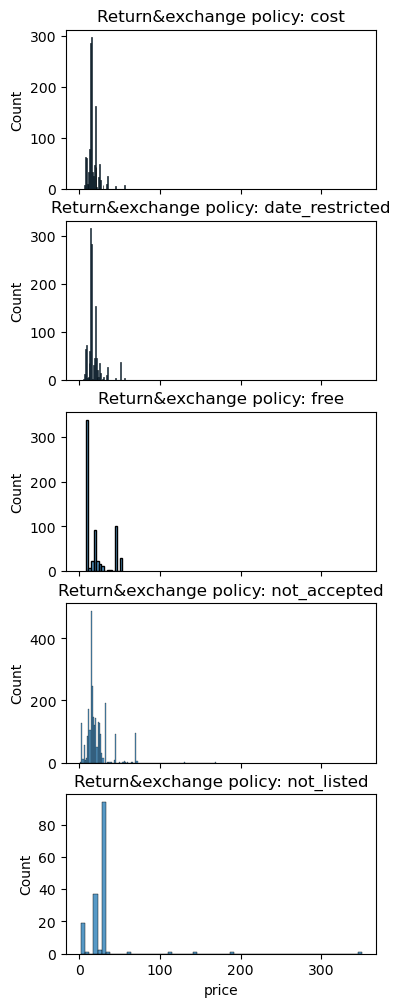

In [86]:
fig, ax = plt.subplots(nrows=5, figsize=(4, 12), sharex=True)
i=0

for policy in np.unique(df.return_and_exchange_policy_category):
    sns.histplot(df.loc[df.return_and_exchange_policy_category==policy, 'price'], ax=ax[i])
    ax[i].set_title(f'Return&exchange policy: {policy}');
    i+=1

## Distribution of Target

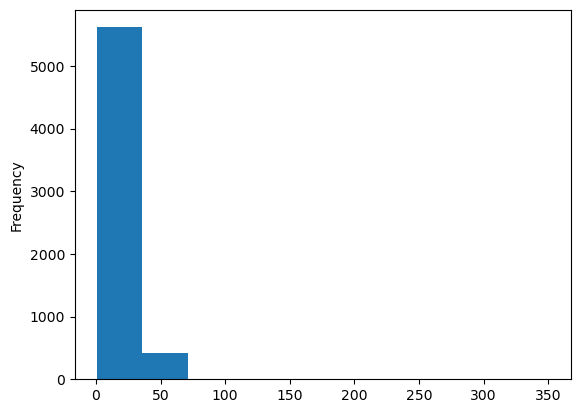

In [31]:
df['price'].plot(kind='hist');

/Users/user/opt/anaconda3/envs/etsy-demand-model/lib/python3.11/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


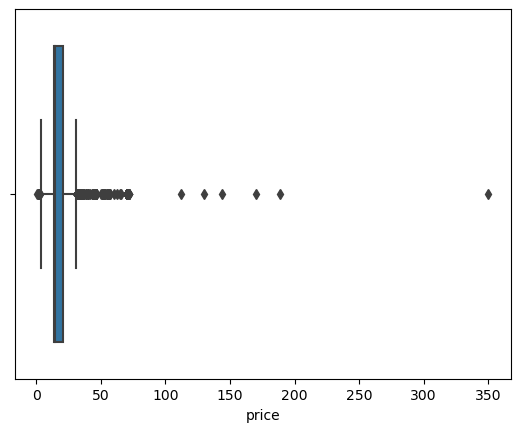

In [32]:
sns.boxplot(df['price']);

In [33]:
df['price'].describe()

count    6040.000000
mean       19.505818
std        12.828481
min         1.020000
25%        13.990000
50%        15.000000
75%        20.990000
max       350.000000
Name: price, dtype: float64

Most candles are priced within a very narrow range. It might be beneficial to remove outliers before modeling.

#### Inspecting Outliers

On brief inspection via random sampling, the higher-priced "candles" tend to be either custom or personalized in some way, or gift sets or sets that contain multiple candles.

## Train Test Split

Drop columns not needed for modeling.

In [93]:
X = df.drop(columns=['product_name', 'product_url', 'brand_type', 'brand_name', 'price', 'currency', 'position',
                     'product_description', 'return_and_exchange_policy', 'item_listing_date', 'early_est_arrival',
                     'later_est_arrival', 'current_date', 'name', 'shop_description', 'location']
                       )
y = df['price'].copy()

X.head()

,avg_rating,review_count,seller_response_time,item_favorites,early_days_to_arrival,later_days_to_arrival,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since,return_and_exchange_policy_category,days_since_listed
index,,,,,,,,,,,,,
29337,4.9766,1363.0,within_a_few_hours,53.0,NaN,NaN,7869.0,872.0,5.0,1375.0,2020.0,not_listed,2.0
144399,4.9691,2420.0,within_a_few_hours,2.0,11.0,17.0,8276.0,1172.0,5.0,2420.0,2017.0,not_accepted,2.0
147618,4.9475,25699.0,within_a_few_hours,1307.0,2.0,7.0,87673.0,10218.0,5.0,25723.0,2013.0,date_restricted,0.0
16123,4.9282,3750.0,none_given,762.0,8.0,9.0,20080.0,3958.0,5.0,3752.0,2011.0,not_accepted,0.0
7595,4.9323,29144.0,within_a_few_hours,17705.0,2.0,10.0,150866.0,21155.0,5.0,29173.0,2011.0,date_restricted,0.0


Train-val-test split.

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.17, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

print(f'Train size: {X_train.shape[0]}')
print(f'Val size: {X_val.shape[0]}')
print(f'Test size: {X_test.shape[0]}')

Train size: 4010
Val size: 1003
Test size: 1027


## Remove Outliers (from Training Data Only)

Remove outliers from the training data only, based on training data statistics.

In [107]:
price_IQR = y_train.quantile(0.75) - y_train.quantile(0.25)
cutoff = 1.5*price_IQR

min_acceptable_price = y_train.quantile(0.25) - cutoff
max_acceptable_price = y_train.quantile(0.75) + cutoff

print(f'Interquartile range: ${round(price_IQR, 2)}')
print(f'Min acceptable price: ${round(min_acceptable_price, 2)}')
print(f'Max acceptable price: ${round(max_acceptable_price, 2)}')

Interquartile range: $7.73
Min acceptable price: $2.4
Max acceptable price: $33.31


In [111]:
X_train_no_outliers = X_train.loc[(y_train > min_acceptable_price) & (y_train < max_acceptable_price)]
y_train_no_outliers = y_train.loc[(y_train > min_acceptable_price) & (y_train < max_acceptable_price)]

In [112]:
print(X_train.shape)
print(X_train_no_outliers.shape)
print(y_train_no_outliers.shape)

(4010, 13)
(3663, 13)
(3663,)


347 outliers were removed from the training data.

## Preprocess Data for Modeling

Column Transformer:

- One hot encode categorical variables.

- Impute numerical features that have missing values with the mean.

- "Pass through" numerical features that do not have missing values.

Pipeline:

- Column transformer

&nbsp; &nbsp; &nbsp; *Applies steps above to appropriate features.*

- Standard scaler

&nbsp; &nbsp; &nbsp; *Scale all of the data, after one hot encoding and imputing, using a standard scaler default strategy.*

In [116]:
ohe = OneHotEncoder(drop='first')
si = SimpleImputer()

categorical_features = ['seller_response_time', 'return_and_exchange_policy_category']

numeric_features = ['avg_rating', 'review_count', 'early_days_to_arrival', 'later_days_to_arrival',
                  'avg_item_review_rounded', 'num_item_reviews', 'days_since_listed']

preprocessor = ColumnTransformer(
    transformers=[
        ("num", si, numeric_features),
        ("cat", ohe, categorical_features),
    ],
    remainder='passthrough' # keep other features
)

ss = StandardScaler()

X_train_preprocessed = pd.DataFrame(ss.fit_transform(preprocessor.fit_transform(X_train_no_outliers)),
                                    columns=preprocessor.get_feature_names_out(),
                                    index=X_train_no_outliers.index)
X_val_preprocessed = pd.DataFrame(ss.transform(preprocessor.transform(X_val)),
                                  columns=preprocessor.get_feature_names_out(),
                                  index=X_val.index)
X_test_preprocessed = pd.DataFrame(ss.transform(preprocessor.transform(X_test)),
                                   columns=preprocessor.get_feature_names_out(),
                                   index=X_test.index)

X_train_preprocessed.head()

,num__avg_rating,num__review_count,num__early_days_to_arrival,num__later_days_to_arrival,num__avg_item_review_rounded,num__num_item_reviews,num__days_since_listed,cat__seller_response_time_within_24_hours,cat__seller_response_time_within_a_few_hours,cat__return_and_exchange_policy_category_date_restricted,cat__return_and_exchange_policy_category_free,cat__return_and_exchange_policy_category_not_accepted,cat__return_and_exchange_policy_category_not_listed,remainder__item_favorites,remainder__num_sales,remainder__num_admirers,remainder__on_etsy_since
index,,,,,,,,,,,,,,,,,
106418,0.095598,3.963731,-0.597592,-0.561669,0.212221,3.963230,-0.542417,-0.556012,0.958019,-0.529877,3.194031,-0.866577,-0.173465,5.541449,3.927893,3.904677,-0.112142
133961,-1.039867,-0.397761,-0.597592,-0.561669,0.212221,-0.399085,-0.492463,1.798522,-1.043820,-0.529877,-0.313084,1.153965,-0.173465,-0.307002,-0.396512,-0.409710,0.844632
609,-1.282285,-0.400251,-0.597592,-0.228560,0.212221,-0.401521,-0.042881,1.798522,-1.043820,1.887232,-0.313084,-0.866577,-0.173465,-0.462886,-0.412880,-0.433033,-0.112142
156440,-0.201156,-0.318877,-0.597592,-1.227886,0.212221,-0.320230,-0.492463,-0.556012,-1.043820,-0.529877,-0.313084,-0.866577,-0.173465,0.253048,-0.317897,-0.304177,0.525708
18790,-0.155180,-0.317684,-0.206470,0.104549,0.212221,-0.318960,-0.342602,-0.556012,0.958019,-0.529877,-0.313084,1.153965,-0.173465,-0.000319,-0.318628,-0.391825,0.844632


## Modeling and Evaluation

**Evaluation metric:** &nbsp; RMSE

**Simple baseline:** &nbsp; Predict the mean (of the training data)

In [117]:
def rmse(y_true, y_pred):
    '''Returns the root mean squared error of a model which makes predictions y_pred for the true values y_true.'''
    
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [121]:
# get predictions for training set
y_pred_train = y_train_no_outliers.mean() * np.ones(y_train.shape)

# get predictions for validation set
y_pred_val = y_train_no_outliers.mean() * np.ones(y_val.shape)

# print results
print(f'Training RMSE: ${round(rmse(y_train, y_pred_train), 2)}')
print(f'Validation RMSE: ${round(rmse(y_val, y_pred_val), 2)}')

Training RMSE: $12.62
Validation RMSE: $11.34


We are looking for a model with a root mean squared error less than \\$11 to \\$12.

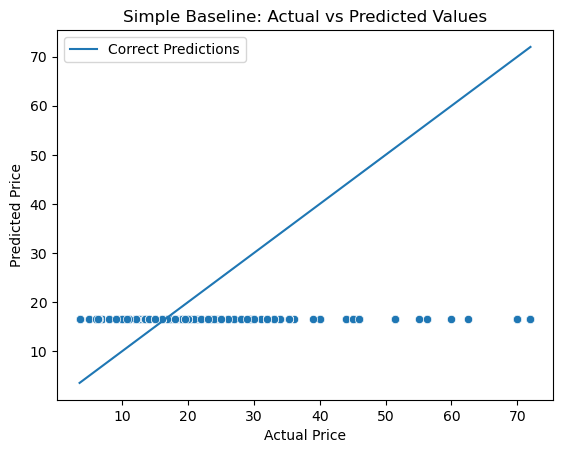

In [127]:
# visualize predictions for validation data
fig, ax = plt.subplots()

sns.scatterplot(x=y_val, y=y_pred_val)
sns.lineplot(x=y_val, y=y_val, label='Correct Predictions')

ax.set(title='Simple Baseline: Actual vs Predicted Values', xlabel='Actual Price', ylabel='Predicted Price');

It makes sense that the simple baseline model would tend to underestimate the price of more expensive candles in the validation data since we obtained the mean from the training data *after* removing outliers (most of which were more expensive personalized candles or sets of candles.) These "outliers" are still present in the validation data.

## Linear Model Approach

### Baseline Multiple Linear Regression

Instantiate and train a baseline multiple linear regression model.

In [130]:
lr = LinearRegression()
lr.fit(X_train_preprocessed, y_train_no_outliers)

print(f'RMSE on Training Data: {np.sqrt(mean_squared_error(y_train_no_outliers, lr.predict(X_train_preprocessed)))}')
print(f'RMSE on Test Data: {np.sqrt(mean_squared_error(y_val, lr.predict(X_val_preprocessed)))}')

RMSE on Training Data: 5.693799749542232
RMSE on Test Data: 10.946042494251751


A baseline multiple linear regression model is

i.) overfit, and

ii.) only slightly better than the simple baseline (in terms of validation RMSE.)

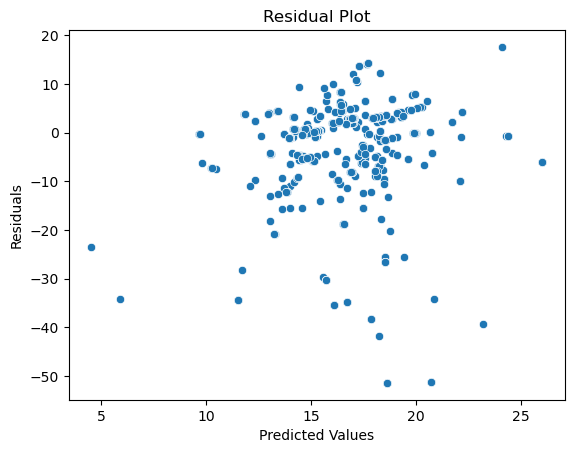

In [131]:
# fitted values versus residuals
y_val_pred = lr.predict(X_val_preprocessed)
y_val_residuals = y_val_pred - y_val

fig, ax = plt.subplots()

sns.scatterplot(x=y_val_pred, y=y_val_residuals)

ax.set(title='Residual Plot', xlabel='Predicted Values', ylabel='Residuals');

There is no clear pattern in the residuals, so it is possible that a linear model is appropriate for this regression problem.

However, the RMSE is not as low as I would like it to be, so I am going to explore the effect of adding polynomial features, anyway.

### Degree 2 Polynomial Terms

In [137]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features_degree_2 = poly.fit_transform(X_train_preprocessed)

Fit a linear model to the training data with degree 2 polynomial features included (including interaction terms.)

In [138]:
lr.fit(poly_features_degree_2, y_train_no_outliers)

print(f'RMSE on Training Data: {np.sqrt(mean_squared_error(y_train_no_outliers, lr.predict(poly_features_degree_2)))}')
print(f'RMSE on Test Data: {np.sqrt(mean_squared_error(y_val, lr.predict(poly.transform(X_val_preprocessed))))}')

RMSE on Training Data: 3.6268646799874227
RMSE on Test Data: 29.55938081595699


This model is significantly worse (in terms of being much more overfit to the training data and having a higher RMSE on the validation data.) I want to briefly check whether L1 regularization improves the model; it's possible that the target has a nonlinear dependence on some features, but not all, and applying L1 regularization is a quick way to prune unnecessary nonlinear (and linear) features.

###  L1 Regularization, Degree 2 Polynomial Terms

In [141]:
l1 = Lasso()

param_grid = [
    {'alpha': [1, 10, 100, 1000, 10000],
     'random_state': [seed]}
]

grid_search = GridSearchCV(l1, param_grid, scoring='neg_root_mean_squared_error', cv=3, return_train_score=True)

grid_search.fit(poly_features_degree_2, y_train_no_outliers)

print(f'Best validation RMSE: {-1*grid_search.best_score_}')

Best validation RMSE: 5.8468736300774795


Also check the training score.

In [157]:
-1 * grid_search.cv_results_['mean_train_score'][grid_search.best_index_] # neg rmse is given

5.8097558865106045

L1 regularization improves the model considerably. The coefficients of most features have been set to zero - which features, polynomial or otherwise, survived?

In [153]:
poly.get_feature_names_out()[np.nonzero(grid_search.best_estimator_.coef_)]

array(['num__avg_rating cat__return_and_exchange_policy_category_not_listed',
       'num__review_count num__num_item_reviews',
       'num__early_days_to_arrival^2', 'num__avg_item_review_rounded^2',
       'num__num_item_reviews^2', 'num__days_since_listed^2',
       'cat__seller_response_time_within_24_hours^2',
       'cat__seller_response_time_within_24_hours cat__return_and_exchange_policy_category_not_accepted',
       'cat__return_and_exchange_policy_category_not_listed^2',
       'remainder__item_favorites remainder__num_admirers'], dtype=object)

Check the assumptions of linear regression.

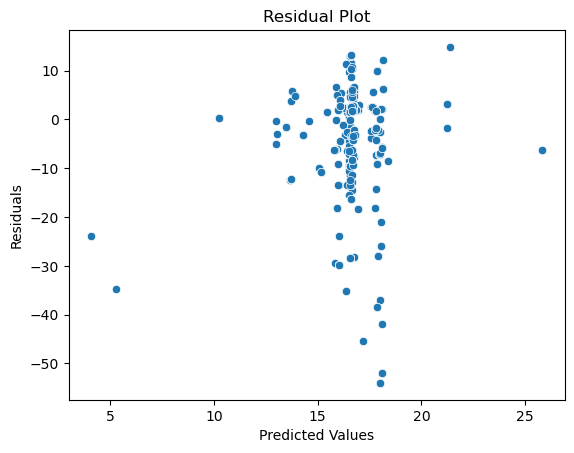

In [155]:
# clone best model and fit to training data (degree 2 polynomial version)
degree_2_model = clone(grid_search.best_estimator_)
degree_2_model.fit(poly_features_degree_2, y_train_no_outliers)

# plot fitted values versus residuals
y_val_pred = degree_2_model.predict(poly.transform(X_val_preprocessed))
y_val_residuals = y_val_pred - y_val

fig, ax = plt.subplots()

sns.scatterplot(x=y_val_pred, y=y_val_residuals)

ax.set(title='Residual Plot', xlabel='Predicted Values', ylabel='Residuals');

There seems to be more of a pattern in the residuals for the degree 2 model, so it is possible that it is not a good fit overall.

Check a degree 3 model with L1 regularization.

### L1 Regularization, Degree 3 Polynomial Terms

In [164]:
poly3 = PolynomialFeatures(degree=3, include_bias=False)
poly_features_degree_3 = poly3.fit_transform(X_train_preprocessed)

l1 = Lasso()

param_grid = [
    {'alpha': [1, 10, 100, 1000, 10000],
     'random_state': [seed]}
]

grid_search = GridSearchCV(l1, param_grid, scoring='neg_root_mean_squared_error', cv=3, return_train_score=True)

grid_search.fit(poly_features_degree_3, y_train_no_outliers)

print(f'Best validation RMSE: {-1*grid_search.best_score_}')

Best validation RMSE: 5.649187024200798


The best model with degree 3 polynomial terms and L1 regularization performs just slightly better than the degree 2 version. There is no need to overcomplicate the model unnecessarily, so this improvement may not be worth pursuing, but let's check the model stats regardless.

Training score:

In [165]:
-1 * grid_search.cv_results_['mean_train_score'][grid_search.best_index_] # neg rmse is given

5.282957621901111

Included features:

In [166]:
poly3.get_feature_names_out()[np.nonzero(grid_search.best_estimator_.coef_)]

array(['num__avg_rating^3',
       'num__avg_rating^2 num__avg_item_review_rounded',
       'num__avg_rating num__days_since_listed^2',
       'num__avg_rating cat__return_and_exchange_policy_category_not_listed^2',
       'num__review_count^2 remainder__item_favorites',
       'num__early_days_to_arrival^3',
       'num__early_days_to_arrival^2 remainder__on_etsy_since',
       'num__early_days_to_arrival num__days_since_listed^2',
       'num__later_days_to_arrival^3',
       'num__later_days_to_arrival^2 num__days_since_listed',
       'num__later_days_to_arrival num__days_since_listed^2',
       'num__later_days_to_arrival cat__seller_response_time_within_24_hours cat__return_and_exchange_policy_category_free',
       'num__later_days_to_arrival remainder__on_etsy_since^2',
       'num__avg_item_review_rounded^3',
       'num__avg_item_review_rounded^2 num__days_since_listed',
       'num__avg_item_review_rounded^2 cat__seller_response_time_within_a_few_hours',
       'num__avg_ite

Assumptions of linear regression:

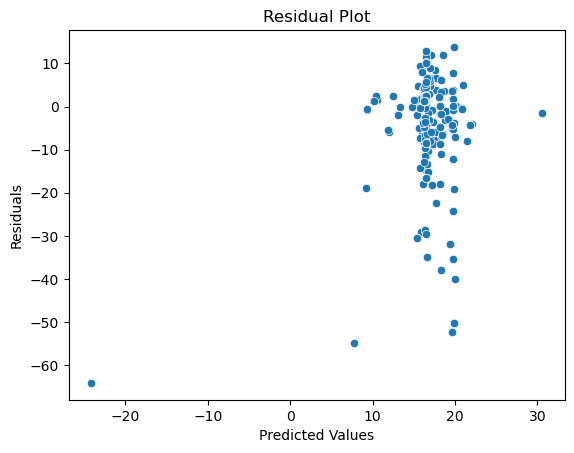

In [167]:
# clone best model and fit to training data (degree 2 polynomial version)
degree_3_model = clone(grid_search.best_estimator_)
degree_3_model.fit(poly_features_degree_3, y_train_no_outliers)

# plot fitted values versus residuals
y_val_pred = degree_3_model.predict(poly3.transform(X_val_preprocessed))
y_val_residuals = y_val_pred - y_val

fig, ax = plt.subplots()

sns.scatterplot(x=y_val_pred, y=y_val_residuals)

ax.set(title='Residual Plot', xlabel='Predicted Values', ylabel='Residuals');

### L1 Regularization, Linear Model

Speaking of overcomplicating the model, I have not tested the effect of using L1 regularization without any polynomial terms - let me try this now to see if we can get a better RMSE with regularization without polynomial terms.

In [160]:
l1 = Lasso()

param_grid = [
    {'alpha': [1, 10, 100, 1000, 10000],
     'random_state': [seed]}
]

grid_search = GridSearchCV(l1, param_grid, scoring='neg_root_mean_squared_error', cv=3, return_train_score=True)

grid_search.fit(X_train_preprocessed, y_train_no_outliers)

print(f'Best validation RMSE: {-1*grid_search.best_score_}')

Best validation RMSE: 6.270683237434787


The best validation RMSE for a linear model with no interaction terms and L1 regularization is higher than that of a model with degree 2 or degree 3 polynomial terms.

### L2 Regularization, Linear Model

Check the effects of L2 regularization on a strictly linear model.

In [163]:
ridge = Ridge()

param_grid = [
    {'alpha': [1, 10, 100, 1000, 10000],
     'random_state': [seed]}
]

grid_search = GridSearchCV(ridge, param_grid, scoring='neg_root_mean_squared_error', cv=3, return_train_score=True)

grid_search.fit(X_train_preprocessed, y_train_no_outliers)

print(f'Best validation RMSE: {-1*grid_search.best_score_}')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Training score:

In [168]:
-1 * grid_search.cv_results_['mean_train_score'][grid_search.best_index_] # neg rmse is given

5.282957621901111

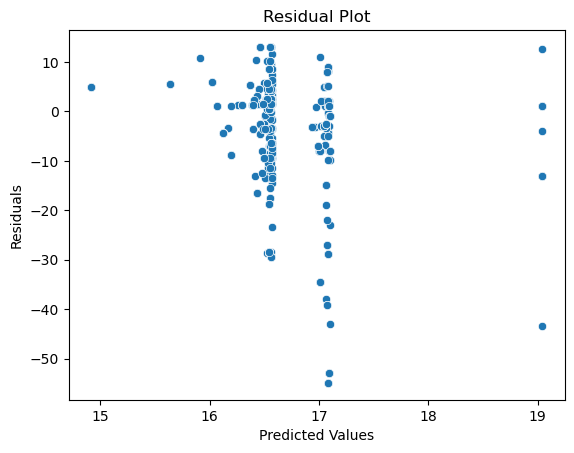

In [169]:
# clone best model and fit to training data (degree 2 polynomial version)
ridge_model = clone(grid_search.best_estimator_)
ridge_model.fit(X_train_preprocessed, y_train_no_outliers)

# plot fitted values versus residuals
y_val_pred = ridge_model.predict(X_val_preprocessed)
y_val_residuals = y_val_pred - y_val

fig, ax = plt.subplots()

sns.scatterplot(x=y_val_pred, y=y_val_residuals)

ax.set(title='Residual Plot', xlabel='Predicted Values', ylabel='Residuals');

Our best linear model so far, by a narrow margin, is still the degree 3 polynomial with L1 regularization with a validation RMSE of \\$5.65.

## Random Forest Regression

### Random Forest Baseline

Instantiate and train a baseline random forest regression model.

In [170]:
rf = RandomForestRegressor(random_state=seed)
rf.fit(X_train_preprocessed, y_train_no_outliers)

print(f'RMSE on Training Data: {np.sqrt(mean_squared_error(y_train_no_outliers, rf.predict(X_train_preprocessed)))}')

print(f'RMSE on Test Data: {np.sqrt(mean_squared_error(y_test, rf.predict(X_test_preprocessed)))}')

RMSE on Training Data: 0.6030366705993918
RMSE on Test Data: 15.562869101287403


Check the maximum depth of trees in this forest.

In [175]:
print(np.mean([tree.get_depth() for tree in rf.estimators_]))
print(np.std([tree.get_depth() for tree in rf.estimators_]))

18.6
1.4966629547095767


Trees in the baseline random forest have a maximum depth generally ranging from 17 to 20.

### Tuning Random Forest

Tune random forest regression.

In [178]:
param_grid = [
    {'max_depth': [1, 5, 10, 15, 20, 25],
     'max_features': [0.5, 0.75, 1],
     'n_estimators': [100, 200],
     'random_state': [seed]}
]

grid_search = GridSearchCV(rf, param_grid, scoring='neg_root_mean_squared_error', cv=3, return_train_score=True)

grid_search.fit(X_train_preprocessed, y_train_no_outliers)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=92308),
             param_grid=[{'max_depth': [1, 5, 10, 15, 20, 25],
                          'max_features': [0.5, 0.75, 1],
                          'n_estimators': [100, 200],
                          'random_state': [92308]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [187]:
print(f'Best validation RMSE: ${round(-1 * grid_search.best_score_, 2)}')

Best validation RMSE: $1.65


In [186]:
print(f"Training RMSE for best model: ${round(-1*grid_search.cv_results_['mean_train_score'][grid_search.best_index_], 2)}")

Training RMSE for best model: $0.65


Visualize predictions for validation data:

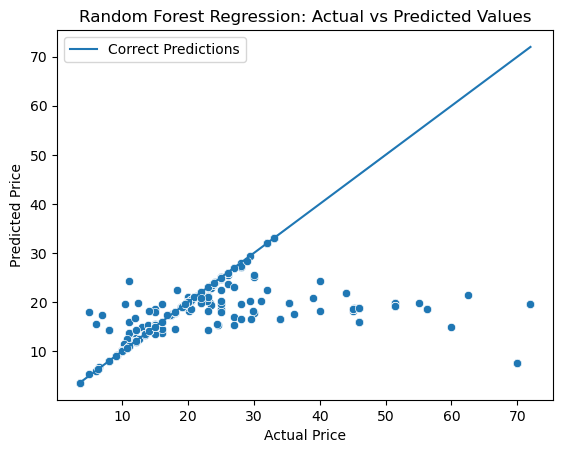

In [191]:
# visualize predictions for validation data
# clone & fit best model
best_rf_model = clone(grid_search.best_estimator_)
best_rf_model.fit(X_train_preprocessed, y_train_no_outliers)
# get predictions for validation data
y_val_pred = best_rf_model.predict(X_val_preprocessed)

# plot actual vs. predicted values
fig, ax = plt.subplots()

sns.scatterplot(x=y_val, y=y_val_pred)
sns.lineplot(x=y_val, y=y_val, label='Correct Predictions')

ax.set(title='Random Forest Regression: Actual vs Predicted Values', xlabel='Actual Price', ylabel='Predicted Price');

The model tends to under-price candles in the validation data that have a price higher than the maximum acceptable price to exclude outliers (unsurprisingly.)

In [192]:
max_acceptable_price

33.30875

We may want to explore including outliers in the training data.

## XG Boost Model

### XG Boost Baseline Model

In [194]:
xgb = XGBRegressor()
xgb.fit(X_train_preprocessed, y_train_no_outliers)

print(f'RMSE on Training Data: ${round(np.sqrt(mean_squared_error(y_train_no_outliers, xgb.predict(X_train_preprocessed))), 2)}')

print(f'RMSE on Test Data: ${round(np.sqrt(mean_squared_error(y_val, xgb.predict(X_val_preprocessed))), 2)}')

RMSE on Training Data: $0.09
RMSE on Test Data: $10.42


### Tuning XG Boost

Tune XG Boost.

In [196]:
param_grid = [
    {'learning_rate': [0.0001, 0.001, 0.01, 0.1],
     'max_depth': [1, 5, 10, 15, 20, 25],
     'subsample': [0.25, 0.5, 0.75, 1],
     'n_estimators': [100, 200],
     'random_state': [seed]}
]

grid_search = GridSearchCV(xgb, param_grid, scoring='neg_root_mean_squared_error', cv=3, return_train_score=True)

grid_search.fit(X_train_preprocessed, y_train_no_outliers)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid=[{'learning_rate': [0.0001, 0.001, 0.01, 0.1],
                          'max_depth': [1, 5, 10, 15, 20, 25],
                          'n_estimators': [100, 200], 'random_state': [92308],
                          'subsample': [0.25, 0.5, 0.75, 1]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [197]:
print(f'Best validation RMSE: ${round(-1 * grid_search.best_score_, 2)}')
print(f"Training RMSE for best model: ${round(-1*grid_search.cv_results_['mean_train_score'][grid_search.best_index_], 2)}")

Best validation RMSE: $1.73
Training RMSE for best model: $0.43


Visualize predictions for validation data:

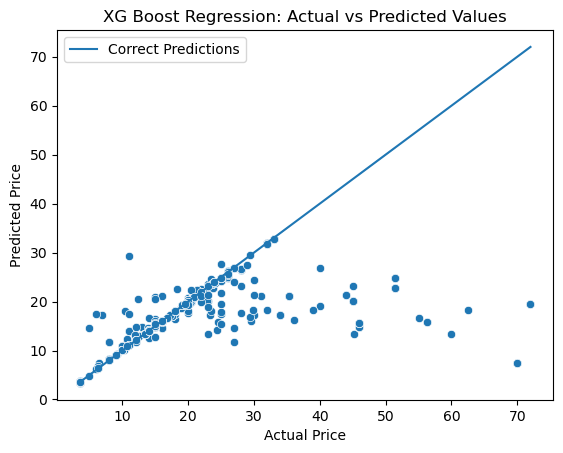

In [199]:
# visualize predictions for validation data
# clone & fit best model
best_xgb_model = clone(grid_search.best_estimator_)
best_xgb_model.fit(X_train_preprocessed, y_train_no_outliers)
# get predictions for validation data
y_val_pred = best_xgb_model.predict(X_val_preprocessed)

# plot actual vs. predicted values
fig, ax = plt.subplots()

sns.scatterplot(x=y_val, y=y_val_pred)
sns.lineplot(x=y_val, y=y_val, label='Correct Predictions')

ax.set(title='XG Boost Regression: Actual vs Predicted Values', xlabel='Actual Price', ylabel='Predicted Price');

---

# To Do

- [ ] Change the below section to dropping *fewer* outliers, and try random forest and xg boost models (quickly) again.
- [ ] Move on to evaluation of the best model on the hold out test set.
- [ ] Include a written summary evaluating the best model: interpreting RMSE, interpreting R^2, and making a comment on the actual vs. predicted visualization.
- [ ] If best model is a random forest, look at feature importance.
- [ ] If you have time, you can try polynomial terms with random forest regression. Not important.
- [ ] Send a message to Abhineet; share best RMSE and improvement over baseline; also share number of models fitted.
- [ ] Summarize modeling process in README; get banner and directory going; include visualizations.
- [ ] Fulfill minimum reproducibility requirements.

---

- [ ] Put together your presentation (pick a slides theme, get visualizations to match, and comb over checklist for project again to be sure that you are meeting all requirements. :) )

---

## Drop More Outliers

Earlier, we set an arbitrary ceiling for the price of a candle at \\$100. Let's try lowering this ceiling, and we can also try using the standard upper limit for outliers (based on the interquartile range.)

In [37]:
price_IQR = df.price.quantile(0.75) - df.price.quantile(0.25)

price_min_acceptable_value = df.price.quantile(0.25) - 1.5*price_IQR
price_max_acceptable_value = df.price.quantile(.75) + 1.5*price_IQR

# drop outliers
df_less_outliers = df.loc[(df.price > price_min_acceptable_value) & (df.price < price_max_acceptable_value)].copy()

Separate features and target.

In [38]:
X = df_less_outliers.drop(columns=['product_name', 'product_url', 'brand_type', 'brand_name', 'price', 'currency',
                                 'position', 'product_description', 'return_and_exchange_policy', 'item_listing_date',
                                 'early_est_arrival', 'later_est_arrival', 'current_date', 'name', 'shop_description',
                                 'location']
                       )
y = df_less_outliers['price'].copy()

X.head()

,avg_rating,review_count,seller_response_time,item_favorites,early_days_to_arrival,later_days_to_arrival,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since,return_and_exchange_policy_category,days_since_listed
index,,,,,,,,,,,,,
144399,4.9691,2420.0,within_a_few_hours,2.0,11.0,17.0,8276.0,1172.0,5.0,2420.0,2017.0,not_accepted,2.0
147618,4.9475,25699.0,within_a_few_hours,1307.0,2.0,7.0,87673.0,10218.0,5.0,25723.0,2013.0,date_restricted,0.0
16123,4.9282,3750.0,none_given,762.0,8.0,9.0,20080.0,3958.0,5.0,3752.0,2011.0,not_accepted,0.0
7595,4.9323,29144.0,within_a_few_hours,17705.0,2.0,10.0,150866.0,21155.0,5.0,29173.0,2011.0,date_restricted,0.0
182537,4.9524,24133.0,within_24_hours,569.0,2.0,10.0,76266.0,17753.0,5.0,24136.0,2010.0,date_restricted,36.0


Train test split.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

Preprocess data for modeling.

In [40]:
ohe = OneHotEncoder(drop='first')
si = SimpleImputer()

categorical_features = ['seller_response_time', 'return_and_exchange_policy_category']

numeric_features = ['avg_rating', 'review_count', 'early_days_to_arrival', 'later_days_to_arrival',
                  'avg_item_review_rounded', 'num_item_reviews', 'days_since_listed']

preprocessor = ColumnTransformer(
    transformers=[
        ("num", si, numeric_features),
        ("cat", ohe, categorical_features),
    ],
    remainder='passthrough' # keep other features
)

ss = StandardScaler()

X_train_preprocessed = pd.DataFrame(ss.fit_transform(preprocessor.fit_transform(X_train)),
                                    columns=preprocessor.get_feature_names_out(),
                                    index=X_train.index)
X_test_preprocessed = pd.DataFrame(ss.transform(preprocessor.transform(X_test)),
                                   columns=preprocessor.get_feature_names_out(),
                                   index=X_test.index)

X_train_preprocessed.head()

,num__avg_rating,num__review_count,num__early_days_to_arrival,num__later_days_to_arrival,num__avg_item_review_rounded,num__num_item_reviews,num__days_since_listed,cat__seller_response_time_within_24_hours,cat__seller_response_time_within_a_few_hours,cat__return_and_exchange_policy_category_date_restricted,cat__return_and_exchange_policy_category_free,cat__return_and_exchange_policy_category_not_accepted,cat__return_and_exchange_policy_category_not_listed,remainder__item_favorites,remainder__num_sales,remainder__num_admirers,remainder__on_etsy_since
index,,,,,,,,,,,,,,,,,
170223,-0.218521,-0.336854,-0.615646,-1.211384,0.231504,-0.336808,0.242656,-0.563848,-1.043663,1.788686,-0.328407,-0.854210,-0.098164,-0.284297,-0.332230,-0.320101,0.549048
104914,0.403123,-0.229340,-0.615646,-0.888734,0.231504,-0.229364,-0.453034,1.773528,-1.043663,-0.559070,-0.328407,1.170673,-0.098164,-0.174289,-0.188076,-0.110565,0.236531
37534,-0.169336,-0.335651,-0.236028,0.079217,0.231504,-0.335605,-0.105189,-0.563848,0.958164,-0.559070,-0.328407,1.170673,-0.098164,-0.449094,-0.332923,-0.403106,0.861565
41947,0.076589,3.717629,-0.615646,-0.888734,0.231504,3.718570,-0.552418,-0.563848,0.958164,-0.559070,3.045006,-0.854210,-0.098164,2.057977,3.690450,3.665791,-0.075985
179924,0.444110,-0.184841,-0.236028,0.079217,0.231504,-0.184797,-0.552418,-0.563848,0.958164,1.788686,-0.328407,-0.854210,-0.098164,-0.118420,-0.106400,-0.352779,0.549048


### Linear Model

In [46]:
lr = LinearRegression()

lr.fit(X_train_preprocessed, y_train)

print(f'RMSE on Training Data: {np.sqrt(mean_squared_error(y_train, lr.predict(X_train_preprocessed)))}')

print(f'RMSE on Test Data: {np.sqrt(mean_squared_error(y_test, lr.predict(X_test_preprocessed)))}')

RMSE on Training Data: 4.806022967430017
RMSE on Test Data: 4.834199987613098


### Random Forest

In [47]:
rf = RandomForestRegressor(random_state=seed)
rf.fit(X_train_preprocessed, y_train)

print(f'RMSE on Training Data: {np.sqrt(mean_squared_error(y_train, rf.predict(X_train_preprocessed)))}')

print(f'RMSE on Test Data: {np.sqrt(mean_squared_error(y_test, rf.predict(X_test_preprocessed)))}')

RMSE on Training Data: 0.5955448181556956
RMSE on Test Data: 1.672302597135333


### XGBoost

In [41]:
xgb = XGBRegressor()
xgb.fit(X_train_preprocessed, y_train)

print(f'RMSE on Training Data: {np.sqrt(mean_squared_error(y_train, xgb.predict(X_train_preprocessed)))}')

print(f'RMSE on Test Data: {np.sqrt(mean_squared_error(y_test, xgb.predict(X_test_preprocessed)))}')

RMSE on Training Data: 0.1221196423863471
RMSE on Test Data: 1.690240821802121


## Next Steps

- [x] Try adding polynomial features. (What is the criteria for feature selection?)
- [ ] Explore the best models.
- [ ] Check assumptions for linear regression. Residual plot, qq plot (conda install statsmodels.)
- [ ] Use statsmodels to assess statistical significance of coefficients. (This could be a way to select polynomial features to include.)
- [ ] Visualize results from random forest model (actual vs. predicted scatter plot, feat importance, what else?)
- [ ] Clean up mark down.
- [ ] Re-position EDA.
- [ ] Clean up web scraping notebook & get minimum reproducibility requirements met.

## Load Data

Blurb about loading data. (Look at [this notebook](web-scraping.ipynb) to see script used to scrape the below data from July 7 - 10, 2023.)

In [3]:
data = pd.read_csv('Data/product_data.csv')
data.head()

,product_name,product_url,brand_type,brand_name,price,currency,position,avg_rating,review_count,product_description
0,Yellow Gold Rustic Unscented Pillar Candle - C...,https://www.etsy.com/listing/171033085/yellow-...,Brand,StillWaterCandles,16.0,USD,1,4.9284,3750.0,This large yellow gold rustic unscented pillar...
1,Pear Green Rustic Textured Unscented Block Pil...,https://www.etsy.com/listing/98864574/pear-gre...,Brand,StillWaterCandles,16.0,USD,2,4.9284,3750.0,This large pear green rustic unscented pillar ...
2,Burnt Orange Rustic Large Unscented Pillar Can...,https://www.etsy.com/listing/172053498/burnt-o...,Brand,StillWaterCandles,16.0,USD,3,4.9284,3750.0,This large burnt orange unscented rustic pilla...
3,Soy Mason Jar Candle////Choose Your Scent//Con...,https://www.etsy.com/listing/270002845/soy-mas...,Brand,TheDancingWick,15.0,USD,4,4.9323,29140.0,These beautiful candles are the perfect additi...
4,Rainbow Candle / Soy Candle with 6 colorful la...,https://www.etsy.com/listing/251774155/rainbow...,Brand,SoapForYourSoul,29.0,USD,5,4.9102,5057.0,Colorful rainbow candle is six layers of scent...


**TO DO **
- [ ] Add brand info.
- [ ] Drop records based on missing brand info.
- [ ] Feature engineering round 1 (number of other candles for sale, etc.)
- [ ] Get a random sample of 10,000 candles.
- [ ] Fix the review_count for candles in sample (get number of review for individual product, as well as for brand as a whole.) Can you also get the earliest and latest estimated arrival, in days from now? And whether or not returns and exchanges are accepted? And the listing date? And the number of favorites?

We have information about 190,128 candles that were for sale on Etsy from July 7-10 in 2023.

In [4]:
print(data.shape)

(190128, 10)


Add newly scraped information about the brand.

In [25]:
brand_data = pd.read_csv('Data/brand_data_raw.csv', index_col=0)
brand_data.head()

,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
0,160candles,Hand-poured candles – with 100% soy wax and 0%...,Europe,68.0,50.0,5.0,21.0,2021.0
1,16wishescandles,Everything SWEET 16 for your MAGICAL day- xoxo,"Dallas, Texas",1533.0,363.0,4.0,280.0,NaN
2,Sunnysmilenyc,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3,27thcandle,NaN,NaN,0.0,0.0,NaN,NaN,NaN
4,320Sycamorecandles,Hand Poured Pure Soy Candles with Cotton Wicks,"Overland, Missouri",6700.0,1009.0,5.0,1715.0,2016.0


Check null values in brand data.

In [31]:
brand_data.isna().sum()

name                         1
shop_description           284
location                   144
num_sales                   30
num_admirers                30
avg_item_review_rounded    436
num_item_reviews           436
on_etsy_since              648
dtype: int64

Drop records with a null value for num_sales or name.

In [34]:
brand_data.dropna(subset=['name', 'num_sales'], axis=0, inplace=True)

Join brand_data to product_data.

In [42]:
query = '''SELECT *
           FROM data
           LEFT JOIN brand_data
           ON data.brand_name = brand_data.name'''

all_data = sqldf(query)

all_data.head()

,product_name,product_url,brand_type,brand_name,price,currency,position,avg_rating,review_count,product_description,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
0,Yellow Gold Rustic Unscented Pillar Candle - C...,https://www.etsy.com/listing/171033085/yellow-...,Brand,StillWaterCandles,16.0,USD,1,4.9284,3750.0,This large yellow gold rustic unscented pillar...,StillWaterCandles,Handmade Rustic Pillar Candles - Free Ship ov...,"Missouri, United States",20080.0,3958.0,5.0,3752.0,2011.0
1,Pear Green Rustic Textured Unscented Block Pil...,https://www.etsy.com/listing/98864574/pear-gre...,Brand,StillWaterCandles,16.0,USD,2,4.9284,3750.0,This large pear green rustic unscented pillar ...,StillWaterCandles,Handmade Rustic Pillar Candles - Free Ship ov...,"Missouri, United States",20080.0,3958.0,5.0,3752.0,2011.0
2,Burnt Orange Rustic Large Unscented Pillar Can...,https://www.etsy.com/listing/172053498/burnt-o...,Brand,StillWaterCandles,16.0,USD,3,4.9284,3750.0,This large burnt orange unscented rustic pilla...,StillWaterCandles,Handmade Rustic Pillar Candles - Free Ship ov...,"Missouri, United States",20080.0,3958.0,5.0,3752.0,2011.0
3,Soy Mason Jar Candle////Choose Your Scent//Con...,https://www.etsy.com/listing/270002845/soy-mas...,Brand,TheDancingWick,15.0,USD,4,4.9323,29140.0,These beautiful candles are the perfect additi...,TheDancingWick,"Personalized Soy Candles, Favors & Sugar scrubs","Bixby, Oklahoma",150866.0,21155.0,5.0,29173.0,2011.0
4,Rainbow Candle / Soy Candle with 6 colorful la...,https://www.etsy.com/listing/251774155/rainbow...,Brand,SoapForYourSoul,29.0,USD,5,4.9102,5057.0,Colorful rainbow candle is six layers of scent...,SoapForYourSoul,"Handmade Soap Company, Soy Candles & Laundry Soap","Conway, South Carolina",13650.0,11583.0,5.0,5060.0,2009.0


We don't need a "brand_name" and a "name" column. Also, "brand_type" is Brand for every record, so we can drop this feature. We also don't need product_url anymore.

In [43]:
all_data.drop(columns=['brand_type', 'name', 'product_url'], inplace=True)

Below are the current counts for all null values in each feature category.

In [44]:
all_data.isna().sum()

product_name                  14
brand_name                     0
price                         19
currency                      19
position                       0
avg_rating                 11330
review_count               11330
product_description           24
shop_description            5242
location                    1689
num_sales                    417
num_admirers                 417
avg_item_review_rounded    11332
num_item_reviews           11332
on_etsy_since              17875
dtype: int64

In [46]:
query = '''SELECT *
           FROM (
                 SELECT brand_name, count() AS candle_count
                 FROM all_data
                 GROUP BY brand_name
                 ) AS candle_count_table
           RIGHT JOIN all_data
           ON candle_count_table.brand_name = all_data.brand_name
           '''

sqldf(query)

,brand_name,candle_count,product_name,brand_name,price,currency,position,avg_rating,review_count,product_description,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
0,160candles,3,Birthdate zodiac candle Leo gift birthday astr...,160candles,28.0,USD,9,5.0000,21.0,Birthdate zodiac candle for Leo – perfect astr...,Hand-poured candles – with 100% soy wax and 0%...,Europe,68.0,50.0,5.0,21.0,2021.0
1,160candles,3,Birthdate zodiac candle Leo gift birthday astr...,160candles,28.0,USD,8,5.0000,21.0,Birthdate zodiac candle for Leo – perfect astr...,Hand-poured candles – with 100% soy wax and 0%...,Europe,68.0,50.0,5.0,21.0,2021.0
2,160candles,3,Birthdate zodiac candle Leo gift birthday astr...,160candles,28.0,USD,10,5.0000,21.0,Birthdate zodiac candle for Leo – perfect astr...,Hand-poured candles – with 100% soy wax and 0%...,Europe,68.0,50.0,5.0,21.0,2021.0
3,16wishescandles,6,16 Wishes Candle Box Gold tin Sweet 16 gift id...,16wishescandles,61.0,USD,30,4.6703,280.0,***optional add on**** a replica of Abby Jense...,Everything SWEET 16 for your MAGICAL day- xoxo,"Dallas, Texas",1533.0,363.0,4.0,280.0,NaN
4,16wishescandles,6,16 Wishes Candle Box Gold tin Sweet 16 gift id...,16wishescandles,61.0,USD,29,4.6703,280.0,***optional add on**** a replica of Abby Jense...,Everything SWEET 16 for your MAGICAL day- xoxo,"Dallas, Texas",1533.0,363.0,4.0,280.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190174,yourclassicshop,7,Beyond Beautiful Cherry Blossom Scented Candle...,yourclassicshop,70.0,USD,11,NaN,NaN,Beyond Beautiful Cherry Blossom Scented Candle...,Loris Gift Shop,None,0.0,0.0,NaN,NaN,NaN
190175,yourclassicshop,7,Beyond Beautiful Cherry Blossom Scented Candle...,yourclassicshop,70.0,USD,4,NaN,NaN,Beyond Beautiful Cherry Blossom Scented Candle...,Loris Gift Shop,None,0.0,0.0,NaN,NaN,NaN
190176,yourclassicshop,7,Beyond Beautiful Cherry Blossom Scented Candle...,yourclassicshop,70.0,USD,11,NaN,NaN,Beyond Beautiful Cherry Blossom Scented Candle...,Loris Gift Shop,None,0.0,0.0,NaN,NaN,NaN
190177,yourclassicshop,7,Beyond Beautiful Cherry Blossom Scented Candle...,yourclassicshop,70.0,USD,10,NaN,NaN,Beyond Beautiful Cherry Blossom Scented Candle...,Loris Gift Shop,None,0.0,0.0,NaN,NaN,NaN


In [45]:
all_data.groupby('brand_name').count()['product_name']

brand_name
160candles               3
16wishescandles          6
1995DesignCompany        7
27thcandle               3
320Sycamorecandles      10
                      ... 
withpoesie               4
woodIandwitchcrafts      7
woodwoodhoney            7
www13grammcom          234
yourclassicshop          7
Name: product_name, Length: 1568, dtype: int64

We will use the following features to build a baseline model:

ITEM INFO

- avg_rating
- review_count (for individual product, not brand!)
-

BRAND INFO

- num_sales
- num_admireres
- avg_item_review_rounded
- num_item_reviews
- on_etsy_since

View five number summary for price, average rating and review count.

In [6]:
data.describe().drop(['position'], axis=1)

,price,avg_rating,review_count
count,190109.000000,178849.000000,178849.000000
mean,19.114158,4.915511,14551.489664
std,12.061501,0.081231,37589.173812
min,0.560000,1.000000,1.000000
25%,13.990000,4.901700,1257.000000
50%,15.000000,4.930000,3857.000000
75%,20.950000,4.953900,8205.000000
max,350.000000,5.000000,169122.000000


**Price**

Mean price of a candle: \\$19

Standard deviation: $12

Median price of a candle: \\$15

Maximum price: \\$350

Minimum price: \\$0.56

^^*Explore outliers*

**Average Rating**

Mean mean rating: 4.92

Standard deviation: 0.08

*Most ratings are quite high.*

In fact, 50\% of ratings lie between 4.9 and 4.95.

The minimum, however, is 1, and the maximum is 5, as expected.

**Review Count**

Mean review count: 14,551

Standard deviation: 37,589

Minimum: 1

Maximum: 169,122

50\% lie between 1257 reviews and 8205 reviews.

**Null values**

A little over 11,000 candles do not have an average rating or review count.

19 candles do not have a price listed.

In [8]:
data.avg_rating.isna().sum()

11279

In [9]:
data.price.isna().sum()

19

**Brand**

100% of candles have a brand listed.

In [10]:
data.brand_type.value_counts()

Brand    190128
Name: brand_type, dtype: int64

In [14]:
data.brand_name.isna().sum()

0

Number of brands in the dataset: 1568

In [21]:
data.brand_name.value_counts().shape

(1568,)

50% of brands have between 6 and 19 candles for sale in the search results.

The most prolific brand has 11,211 candles for sale in this dataset alone.

25% of brands have 6 or fewer candles for sale in this dataset.

In [12]:
data.brand_name.value_counts().describe()

count     1568.000000
mean       121.255102
std        703.398801
min          1.000000
25%          6.000000
50%          7.000000
75%         19.000000
max      11211.000000
Name: brand_name, dtype: float64

**Product Description**

24 candles are missing a product description.

In [16]:
data.product_description.isna().sum()

24

The "average" product description contains 452 words, but there is a HUGE standard deviation! In reality, 75% of product descriptions are shorter than 389 words, and 50% have fewer than 233 words.

In [18]:
data.product_description.dropna().map(lambda x: len(x.split())).describe()

count    190104.000000
mean        452.528279
std         892.365711
min           1.000000
25%         146.000000
50%         233.000000
75%         389.000000
max        5602.000000
Name: product_description, dtype: float64

TO DO:

- [ ] Look at top words in product descriptions and product names

**Product Name**

14 candles do not have a product name.

In [19]:
data.product_name.isna().sum()

14

The "average" product name is 16 words long, which is relatively close to the median length as well.

In [20]:
data.product_name.dropna().map(lambda x: len(x.split())).describe()

count    190114.000000
mean         16.107656
std           6.302984
min           1.000000
25%          11.000000
50%          17.000000
75%          22.000000
max          32.000000
Name: product_name, dtype: float64